In [75]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import stats
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import plotly.graph_objects as go
colors = ['#082040', '#175073', '#3285A6', '#B8D0D9', '#6CC5D9']

In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [77]:
import pickle

In [78]:
df = pd.read_csv(r'C:\Users\Ксения\Project\Magnet_Exchange_bias\data\Bias_data_2.csv')

In [79]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       533 non-null    int64  
 1   volume             533 non-null    float64
 2   area               533 non-null    float64
 3   Unnamed: 0         533 non-null    int64  
 4   c1                 533 non-null    object 
 5   c2                 322 non-null    object 
 6   c3                 9 non-null      object 
 7   chemical_formula   533 non-null    object 
 8   crystal_structure  533 non-null    int64  
 9   z                  509 non-null    float64
 10  id                 533 non-null    int64  
 11  space_group_shell  533 non-null    int64  
 12  structure          533 non-null    object 
 13  structure_         533 non-null    object 
 14  formula_combined   533 non-null    object 
 15  coer_oe            533 non-null    float64
 16  exc_bias_oe        533 non

Пропуски в ожидемых местах среди целевых пременных пропусков нет

In [80]:
print(df.isna().sum(), df.shape, df.info(), sep=', ', end='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       533 non-null    int64  
 1   volume             533 non-null    float64
 2   area               533 non-null    float64
 3   Unnamed: 0         533 non-null    int64  
 4   c1                 533 non-null    object 
 5   c2                 322 non-null    object 
 6   c3                 9 non-null      object 
 7   chemical_formula   533 non-null    object 
 8   crystal_structure  533 non-null    int64  
 9   z                  509 non-null    float64
 10  id                 533 non-null    int64  
 11  space_group_shell  533 non-null    int64  
 12  structure          533 non-null    object 
 13  structure_         533 non-null    object 
 14  formula_combined   533 non-null    object 
 15  coer_oe            533 non-null    float64
 16  exc_bias_oe        533 non

In [44]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'c1', 'c2', 'c3', 'structure_', 'chemical_formula']) # Колонку structure - нужно будет как-то закодировать 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   volume             533 non-null    float64
 1   area               533 non-null    float64
 2   chemical_formula   533 non-null    object 
 3   crystal_structure  533 non-null    object 
 4   z                  509 non-null    float64
 5   id                 533 non-null    int64  
 6   space_group_shell  533 non-null    int64  
 7   structure          533 non-null    object 
 8   formula_combined   533 non-null    object 
 9   coer_oe            533 non-null    float64
 10  exc_bias_oe        533 non-null    float64
 11  fc_field_t         533 non-null    float64
 12  h_range_max_koe    533 non-null    float64
 13  y                  533 non-null    float64
 14  mr (emu/g)         533 non-null    float64
 15  sat_em_g           533 non-null    float64
 16  shape              533 non

Столбец structure имеет в себе формулы с структурой формулы ядро/оболочка, поэтому она для модели не будет иметьсмысла, но для интерпритации важна, поэтому совместим её знчаения с колонкой id, которая тоже не несёт никакого знания о наносатицах напрямую. Создадим словарь, где каждый id - structure

In [45]:
print(len(df['id'].unique())) # Эта колнка состоит только из уникальных значений

533


In [46]:
dict_structure = {} # Словарь для кодирования
# Проходимся по каждой строке DataFrame и добавляем в словарь пару id-structure
for idx, row in df.iterrows():
    dict_structure[row['id']] = row['chemical_formula']

# Пример значения id, для которого мы хотим декодировать structure
id_value = 123

In [47]:
# Сохраняем словарь в файл с помощью pickle(пакет помогает сохранять данные и загружать обратно)
with open('dict_structure.pkl', 'wb') as f:
    pickle.dump(dict_structure, f)

In [48]:
# Проверка
decoded_structure = dict_structure[id_value]
print(decoded_structure)

['FeO', 'Fe3O4']


In [49]:
del df['structure']
del df['chemical_formula']

In [50]:
print(df['crystal_structure'])

0        hexagonal, cubic 
1             cubcic, cube
2                    cubic
3                    cubic
4                    cubic
              ...         
528    orthorhombic, cubic
529    orthorhombic, cubic
530    orthorhombic, cubic
531    orthorhombic, cubic
532    orthorhombic, cubic
Name: crystal_structure, Length: 533, dtype: object


In [51]:
print(df['crystal_structure'].unique()) # Разделиим и стандартизируемм значения, а потом перведём их в цифры и снова склеим

['hexagonal, cubic ' 'cubcic, cube' 'cubic' 'orthorhombic' 'cubic, cubic'
 'trigonal' 'cubic, trigonal' 'tetragonal' 'cubic, monoclinic'
 'cube, cube' 'trigonal, orthorhombic' 'tetragonal, cubic' 'cube'
 'cubic, orthorhombic' 'cubic,  cubic' 'triclinic,cubic ' 'hexagonal'
 'hexagonal, cubic' 'cubic, tetrahedral' 'cubic ' 'cubic, tetragonal'
 'orthorhombic, cubic' 'cubic,  trigonal' 'monoclinic, cubic' 'monoclinic'
 'cubic, hexagonal']


In [52]:
dict_crystal_str = {
    'triclinic': 1, 'monoclinic': 2, 'orthorhombic': 3,
    'tetragonal': 4, 'trigonal': 5, 'hexagonal': 6,
    'cubic': 7, 'cube': 7
}

In [53]:
# Функция для кодирования списка значений в соответствии с словарем
def encode_crystal_list(crystal_list):
    return [dict_crystal_str[crystal] for crystal in crystal_list]

In [54]:
df = df.drop(columns=['crystal_structure', 'formula_combined', 'mass_ratio']) # object

In [55]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   volume             533 non-null    float64
 1   area               533 non-null    float64
 2   z                  509 non-null    float64
 3   id                 533 non-null    int64  
 4   space_group_shell  533 non-null    int64  
 5   coer_oe            533 non-null    float64
 6   exc_bias_oe        533 non-null    float64
 7   fc_field_t         533 non-null    float64
 8   h_range_max_koe    533 non-null    float64
 9   y                  533 non-null    float64
 10  mr (emu/g)         533 non-null    float64
 11  sat_em_g           533 non-null    float64
 12  shape              533 non-null    float64
 13  space_group_core   533 non-null    float64
 14  temperature_k      533 non-null    float64
 15  ver_shift_emu_g    533 non-null    float64
 16  x                  533 non

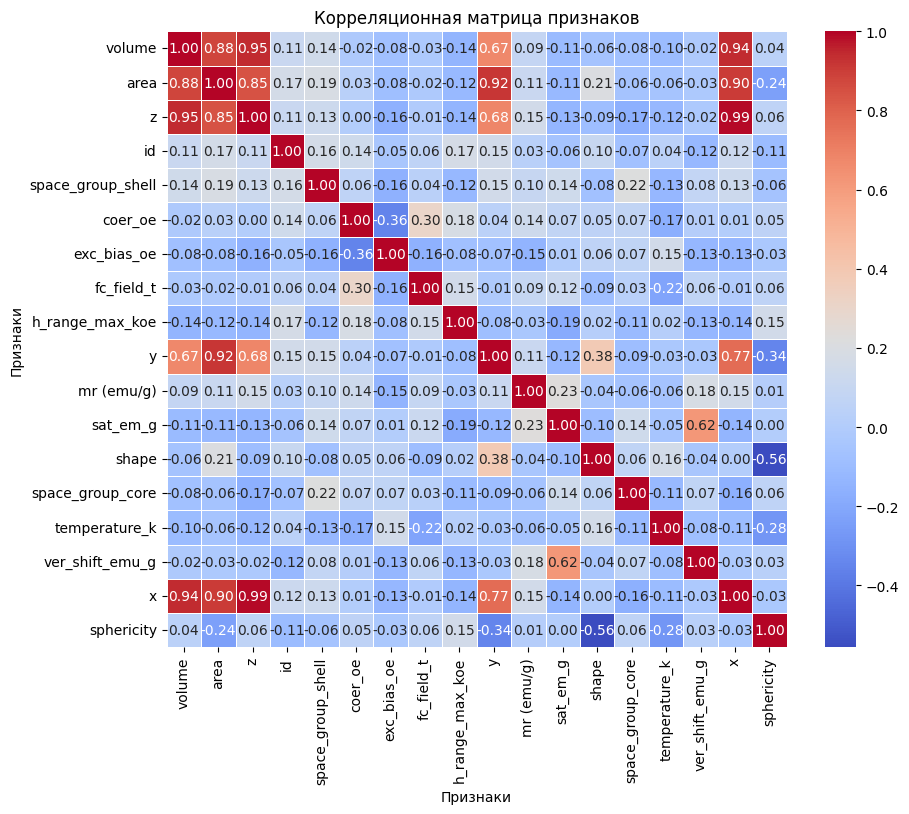

In [56]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.7)
plt.title('Корреляционная матрица признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

In [57]:
df['area/volume'] = df['area'] / df['volume']

In [58]:
df = df.drop(columns=['x', 'y', 'z', 'area', 'volume']) # Корреляции

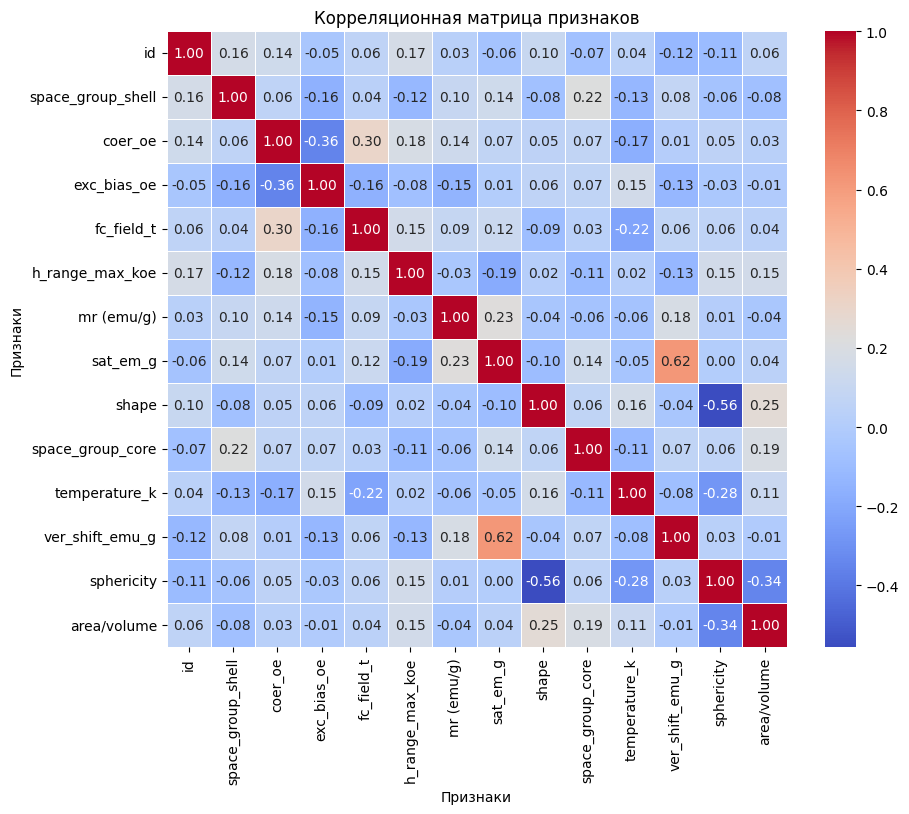

In [59]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.7)
plt.title('Корреляционная матрица признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

In [60]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

In [61]:
#Построим график распределения целевой переменной
fig = make_subplots(rows=1, cols=2, subplot_titles=['Histogram for exchange bias', 'Violin Plot for solubility'])

# Histogram
hist_fig = px.histogram(df, x="exc_bias_oe", nbins = 60,
                 color_discrete_sequence = colors,
                 opacity = 0.7)

fig.add_trace(hist_fig['data'][0], row=1, col=1) # Adding a graph indicating the location

# Violin plot
violin_fig = px.violin(df, y="exc_bias_oe", color_discrete_sequence = colors, box = True)
fig.add_trace(violin_fig['data'][0], row=1, col=2) # Adding a graph indicating the location

# Setting up the layout
fig.update_layout(showlegend=False, title_text="Pic for exchange bias")

# Graph display
display(fig)

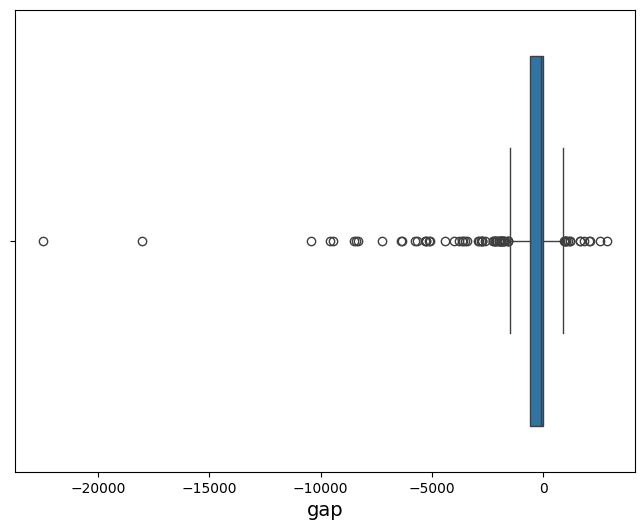

In [62]:
plt.figure(figsize=(8, 6)) # Создание ящика с усами для столбца 'exc_bias_oe'
sns.boxplot(x=df['exc_bias_oe'])
plt.xlabel('gap', fontsize=14) # Добавление названия оси x
plt.show()

In [63]:
#Ещё посмотрим с помощью интерквартального расстояния, так будет понятней, значения за первым и 3 квартилям будут выбросами
def detect_outliers_iqr(data, threshold=1.5):
    """
    Detect outliers using the Interquartile Range (IQR) method.

    Parameters:
        data (array-like): Input data.
        threshold (float): Multiplier for the IQR to determine the outlier cutoff.

    Returns:
        outliers (array-like): Array containing the indices of outlier data points.
    """
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (threshold * iqr)
    upper_bound = quartile_3 + (threshold * iqr)
    outliers = np.where((data < lower_bound) | (data > upper_bound))[0]
    return outliers

# Example usage:
outliers = detect_outliers_iqr(df['exc_bias_oe'])
print("Индексы выбросов:", outliers)
print("Значения выбросов:", [df['exc_bias_oe'][i] for i in outliers])

Индексы выбросов: [ 16  53  54  63  72  73  75 108 112 113 119 120 121 123 124 136 137 140
 141 149 150 151 152 153 157 171 173 189 190 191 192 193 194 208 209 215
 228 234 267 272 375 390 391 398 399 400 401 402 403 433 448 473 488 489
 490 491 492 504 506 507 514 515 516 517 518 519 520 521 522 532]
Значения выбросов: [-2157.0, -1812.0, -7238.0, -2878.5, -1600.0, 1825.0, 1650.0, -1804.0, -2762.0, -2250.0, -2188.0, -1600.0, -3500.0, -22459.0, -18003.0, -2275.0, -2120.0, -1972.0, -1814.6, -1877.782, -1877.782, -1711.4, -2800.0, -2600.0, -3650.0, -2750.0, 984.37, -3430.0, -4020.0, -5100.0, -3773.58, -5283.0, -5283.0, 2560.0, 2120.0, -3600.0, -1879.0, -2173.9, 2068.9, 2847.4576, 1195.65, -4408.0, -6350.0, -2083.0, -5121.9692, -10414.0, -8514.585999999998, -6372.383, -5325.26, -2755.17, -2000.0, -1756.75, -5753.62, -8310.58, -9418.761, -9573.644, -8410.919999999998, -5653.0, -2920.0, -1580.0, 1662.94, 1220.4, 1116.5300000000002, 1029.63, 1002.68, 960.57, 949.12, -1895.0, -1907.9, -1976.41

In [64]:
# Detect outliers
outliers = detect_outliers_iqr(df['exc_bias_oe'])

# Получение значений выбросов
outlier_values = df.loc[outliers, 'exc_bias_oe']

# Scatter plot
fig = go.Figure()

# Plot all data points
fig.add_trace(go.Scatter(x=np.arange(len(df['exc_bias_oe'])), y=df['exc_bias_oe'], mode='markers', name='Data Points', marker=dict(color=colors[2])))

# Highlight outliers
fig.add_trace(go.Scatter(x=outliers, y=outlier_values, mode='markers', marker=dict(color=colors[0]), name='Outliers'))

# Add layout
fig.update_layout(title='Outlier Detection Using IQR Method',
                  xaxis_title='Index',
                  yaxis_title='Value')

# Show plot
display(fig)

In [65]:
out_data = df.drop(outliers)
print(out_data.head())

   id  space_group_shell   coer_oe  exc_bias_oe  fc_field_t  h_range_max_koe  \
0   1                227  27800.00     -1132.00         5.0             50.0   
1   2                227   7800.00      -406.00         5.0             50.0   
2   3                  0     24.80        51.34         0.0             10.0   
3   4                  0     90.20       108.18         0.0             10.0   
4   5                  0     40.07         8.92         0.0             10.0   

   mr (emu/g)  sat_em_g  shape  space_group_core  temperature_k  \
0    13.76705   52.1524    1.0             186.0            5.0   
1    43.26420   83.1400    1.0             225.0            5.0   
2     0.00780    2.2900    1.0             227.0          300.0   
3     0.02180    2.4300    1.0             227.0          300.0   
4     0.34980   16.1500    1.0             227.0          300.0   

   ver_shift_emu_g  sphericity  area/volume  
0              0.0         1.0     0.405405  
1              0.0      

In [66]:
df = out_data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 531
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 463 non-null    int64  
 1   space_group_shell  463 non-null    int64  
 2   coer_oe            463 non-null    float64
 3   exc_bias_oe        463 non-null    float64
 4   fc_field_t         463 non-null    float64
 5   h_range_max_koe    463 non-null    float64
 6   mr (emu/g)         463 non-null    float64
 7   sat_em_g           463 non-null    float64
 8   shape              463 non-null    float64
 9   space_group_core   463 non-null    float64
 10  temperature_k      463 non-null    float64
 11  ver_shift_emu_g    463 non-null    float64
 12  sphericity         463 non-null    float64
 13  area/volume        463 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 54.3 KB
None


In [67]:
#Построим график распределения целевой переменной
fig = make_subplots(rows=1, cols=2, subplot_titles=['Histogram for exchange bias', 'Violin Plot for solubility'])

# Histogram
hist_fig = px.histogram(df, x="exc_bias_oe", nbins = 60,
                 color_discrete_sequence = colors,
                 opacity = 0.7)

fig.add_trace(hist_fig['data'][0], row=1, col=1) # Adding a graph indicating the location

# Violin plot
violin_fig = px.violin(df, y="exc_bias_oe", color_discrete_sequence = colors, box = True)
fig.add_trace(violin_fig['data'][0], row=1, col=2) # Adding a graph indicating the location

# Setting up the layout
fig.update_layout(showlegend=False, title_text="Pic for exchange bias after outliers")

# Graph display
print(display(fig))

None


In [68]:
exc_bias_oe = df['exc_bias_oe']
id = df['id']

In [69]:
# Standardization
scaler = StandardScaler()
df_enc_standardized = scaler.fit_transform(df)

# Convert the scaled array into a DataFrame
df_enc_standardized = pd.DataFrame(df_enc_standardized, columns=df.columns)
df_enc_standardized['id'] = id
df_enc_standardized['exc_bias_oe'] = exc_bias_oe

df = df_enc_standardized
print(df)

        id  space_group_shell   coer_oe  exc_bias_oe  fc_field_t  \
0      1.0           0.975948  7.110630     -1132.00    0.675149   
1      2.0           0.975948  1.560885      -406.00    0.675149   
2      3.0          -1.135001 -0.596634        51.34   -0.584811   
3      4.0          -1.135001 -0.578487       108.18   -0.584811   
4      5.0          -1.135001 -0.592397         8.92   -0.584811   
..     ...                ...       ...          ...         ...   
458  459.0           0.957350 -0.303064         0.00   -0.332819   
459  460.0           0.957350 -0.285815         0.00   -0.080827   
460  461.0           0.957350 -0.253882         0.00    0.171165   
461  462.0           0.957350 -0.236539      -769.00    0.423157   
462  463.0           0.957350 -0.200438      -280.00    0.675149   

     h_range_max_koe  mr (emu/g)  sat_em_g     shape  space_group_core  \
0           0.486009    0.032612  0.449019 -0.432472         -0.110535   
1           0.486009    1.480796  1

In [70]:
from sklearn.impute import KNNImputer

# Создание экземпляра KNNImputer
imputer = KNNImputer()

# Применение импутации к столбцу 'exc_bias_oe'
df['exc_bias_oe'] = imputer.fit_transform(df[['exc_bias_oe']])

In [71]:
missing_values = df.isnull().sum()
print(missing_values)

id                   51
space_group_shell     0
coer_oe               0
exc_bias_oe           0
fc_field_t            0
h_range_max_koe       0
mr (emu/g)            0
sat_em_g              0
shape                 0
space_group_core      0
temperature_k         0
ver_shift_emu_g       0
sphericity            0
area/volume           0
dtype: int64


In [72]:
df = df.drop(columns=['id']) # Просто порядковый номер моих наночастиц, чтобы отличать их друг от друга

In [73]:
df.to_csv(r'C:\Users\Ксения\Project\Magnet_Exchange_bias\data\Bias_data_3.csv')